# Cyber Security Packet Analysis Classification Model

**Objective:**  
In this project, we'll build a classification model using a Random Forest classifier to detect malicious network packets from a dataset. We'll go step by step—loading the data, preprocessing it, visualizing, training the model, and finally evaluating its performance.

---

## Step 1: Import Libraries

*Notes:*  
- We need to import libraries for data manipulation (Pandas, NumPy), visualization (Matplotlib, Seaborn), and machine learning (Scikit-learn).  
- This cell sets up our coding environment.



In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning tools from Scikit-learn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# For parallel coordinates plot
from pandas.plotting import parallel_coordinates

# Set a nice style for our plots
sns.set(style='whitegrid')

print("Libraries imported successfully!")


Libraries imported successfully!


## Step 2: Load and Explore the Dataset

*Notes:*  
- load the dataset (`traffic.csv`).  
- Clean up column names (remove extra spaces).  
- Print out the shape and a preview to check everything is as expected.




In [4]:
# Define the path to the dataset
file_path = "traffic.csv"  # Ensure your CSV file is in the same folder or update the path accordingly

# Load the dataset
df = pd.read_csv(file_path)

# Clean column names: remove any leading/trailing spaces
df.columns = df.columns.str.strip()

# Check the dataset shape and preview the data
print("Dataset Shape:", df.shape)
print(df.head())


Dataset Shape: (191033, 79)
   Destination Port  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0              3268      112740690                 32                      16   
1               389      112740560                 32                      16   
2                 0      113757377                545                       0   
3              5355         100126                 22                       0   
4                 0          54760                  4                       0   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                         6448                         1152   
1                         6448                         5056   
2                            0                            0   
3                          616                            0   
4                            0                            0   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                    403       

## Step 3: Data Preprocessing

### 3.1 Encode the Target Variable

*Notes:*  
- Our target variable is `Label`. We need to convert it into numeric values using `LabelEncoder`.
- This is important because machine learning models work with numbers.


In [5]:
# Encode the target variable (Label)
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

# Check the distribution of labels
print("Label distribution:\n", df['Label'].value_counts())


Label distribution:
 Label
0    189067
1      1966
Name: count, dtype: int64


### 3.2 Select Features and Clean Data

*Notes:*  
- We select only the features we believe are useful for detecting malicious packets.
- Convert the feature columns to numeric (errors become NaN), replace infinite values, drop missing values, and cap outliers at the 99th percentile.


In [6]:
# Define a list of features to use
features = [
    'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
    'Fwd Packet Length Mean', 'Bwd Packet Length Mean',
    'Flow Bytes/s', 'Flow Packets/s', 'SYN Flag Count', 'FIN Flag Count',
    'Packet Length Mean', 'Packet Length Std'
]

# Create a new DataFrame with the selected features and the target label
df_selected = df[features + ['Label']].copy()

# Convert features to numeric values, forcing errors into NaN
df_selected[features] = df_selected[features].apply(pd.to_numeric, errors='coerce')

# Replace any infinite values with NaN
df_selected.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with missing values
df_selected.dropna(inplace=True)

# Cap extreme values at the 99th percentile to manage outliers
for col in features:
    cap = df_selected[col].quantile(0.99)
    df_selected[col] = np.where(df_selected[col] > cap, cap, df_selected[col])

print("Preprocessed dataset shape:", df_selected.shape)


Preprocessed dataset shape: (190911, 12)


### 3.3 Normalize the Features

*Notes:*  
- Normalizing data helps our model perform better by scaling all features to have similar ranges.
- We use `StandardScaler` to scale the features.


In [5]:
# Normalize features: scale to mean = 0 and std = 1
scaler = StandardScaler()
df_selected[features] = scaler.fit_transform(df_selected[features])

# Show the first few rows to confirm normalization
print("Normalized data preview:")
print(df_selected.head())


Normalized data preview:
   Flow Duration  Total Fwd Packets  Total Backward Packets  \
0       3.295350           2.938685                1.120877   
1       3.295346           2.938685                1.120877   
2       3.328490           6.228444               -0.459694   
3      -0.376273           1.842098               -0.459694   
4      -0.377752          -0.131757               -0.459694   

   Fwd Packet Length Mean  Bwd Packet Length Mean  Flow Bytes/s  \
0                2.814153               -0.352538     -0.277818   
1                2.814153                0.580217     -0.277807   
2               -0.852372               -0.627777     -0.277841   
3               -0.342880               -0.627777     -0.275792   
4               -0.852372               -0.627777     -0.277841   

   Flow Packets/s  SYN Flag Count  FIN Flag Count  Packet Length Mean  \
0       -0.287015        4.318464       -0.114206            0.400530   
1       -0.287015        4.318464       -0.1142

## Step 4: Data Visualization

*Notes:*  
We'll create several visualizations to understand our data better.  
1. **Correlation Heatmap:** Shows relationships between features.  
2. **Count Plot:** Visualizes the distribution of normal vs. malicious packets.


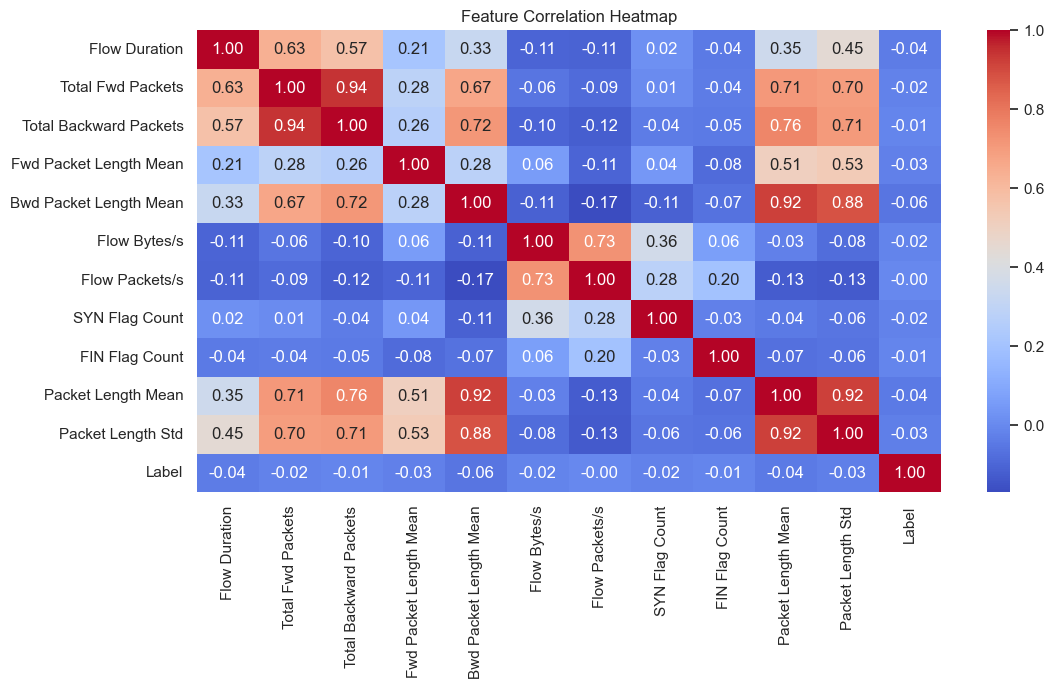

In [7]:
# Visualization 1: Correlation Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df_selected.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()


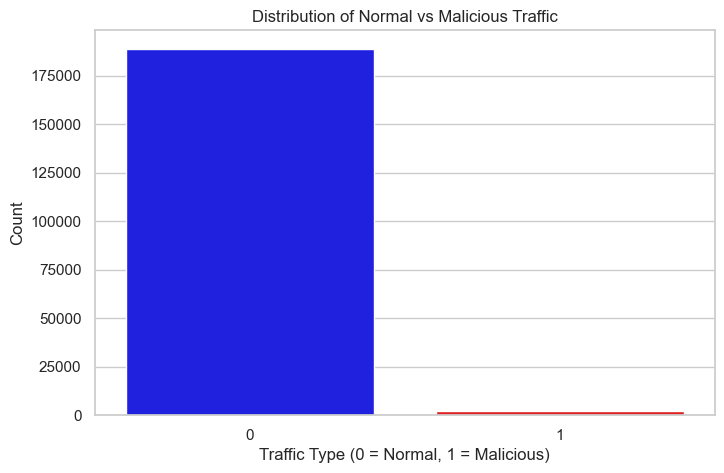

In [8]:
# Visualization 2: Distribution of Normal vs. Malicious Traffic
plt.figure(figsize=(8, 5))
sns.countplot(x="Label", data=df_selected, hue="Label", palette={0:"blue", 1:"red"})
plt.title("Distribution of Normal vs Malicious Traffic")
plt.xlabel("Traffic Type (0 = Normal, 1 = Malicious)")
plt.ylabel("Count")
plt.legend([],[], frameon=False)
plt.show()


## Step 5: Split Data and Train the Model

*Notes:*  
- We split our dataset into training (80%) and testing (20%) sets.
- Then, we train a Random Forest classifier on the training set.


In [8]:
# Define features (X) and target (y)
X = df_selected[features]
y = df_selected['Label']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model: print classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     37765
           1       1.00      0.62      0.77       418

    accuracy                           1.00     38183
   macro avg       1.00      0.81      0.88     38183
weighted avg       1.00      1.00      1.00     38183

Confusion Matrix:
 [[37765     0]
 [  159   259]]


## Step 6: Additional Visualizations

### 6.1 ROC Curve

*Notes:*  
- The ROC curve shows the trade-off between the true positive rate and false positive rate.
- AUC (Area Under the Curve) gives a summary metric of performance.


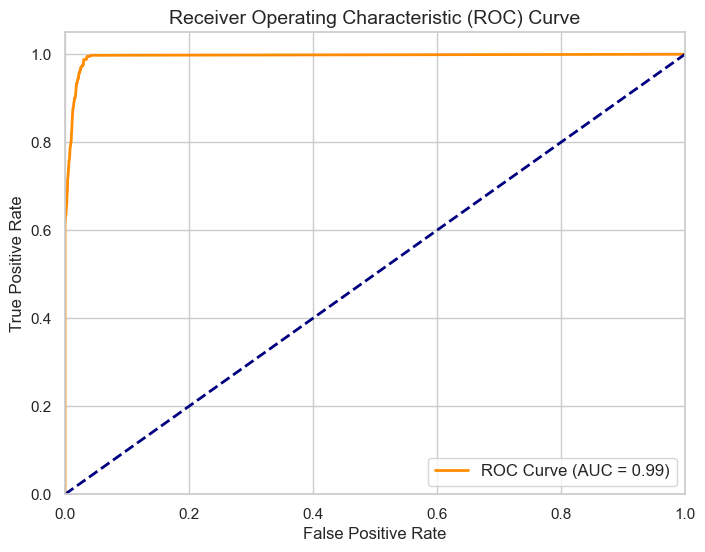

In [9]:
# Get probabilities for the positive class (malicious)
y_proba = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.show()


### 6.2 Feature Importance

*Notes:*  
- This visualization shows which features the Random Forest model considers most important.


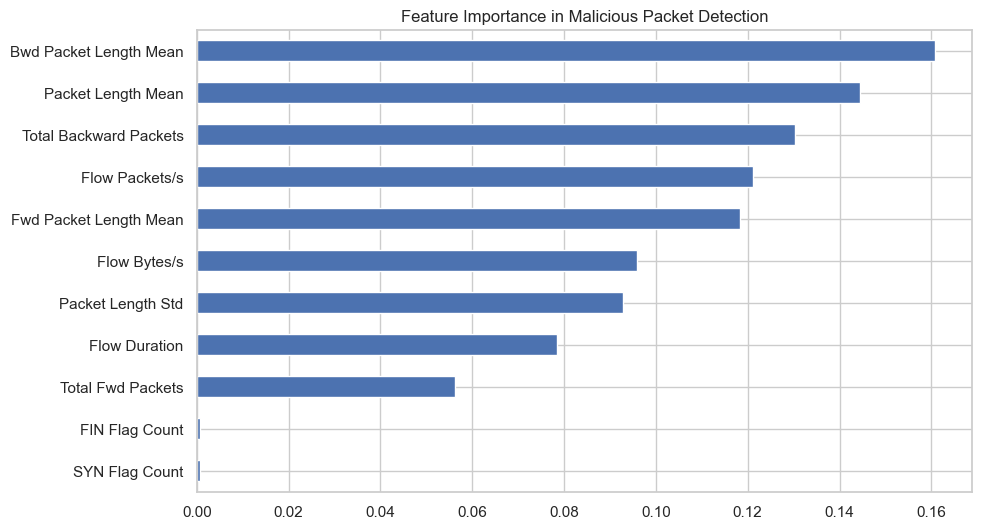

In [10]:
# Plot feature importance
feature_importances = pd.Series(model.feature_importances_, index=features)
feature_importances.sort_values().plot(kind='barh', figsize=(10, 6), title='Feature Importance in Malicious Packet Detection')
plt.show()


### 6.3 Parallel Coordinates Plot

*Notes:*  
- A parallel coordinates plot helps visualize the variation in multiple features at once.
- We sample a subset of the data to keep the plot readable.


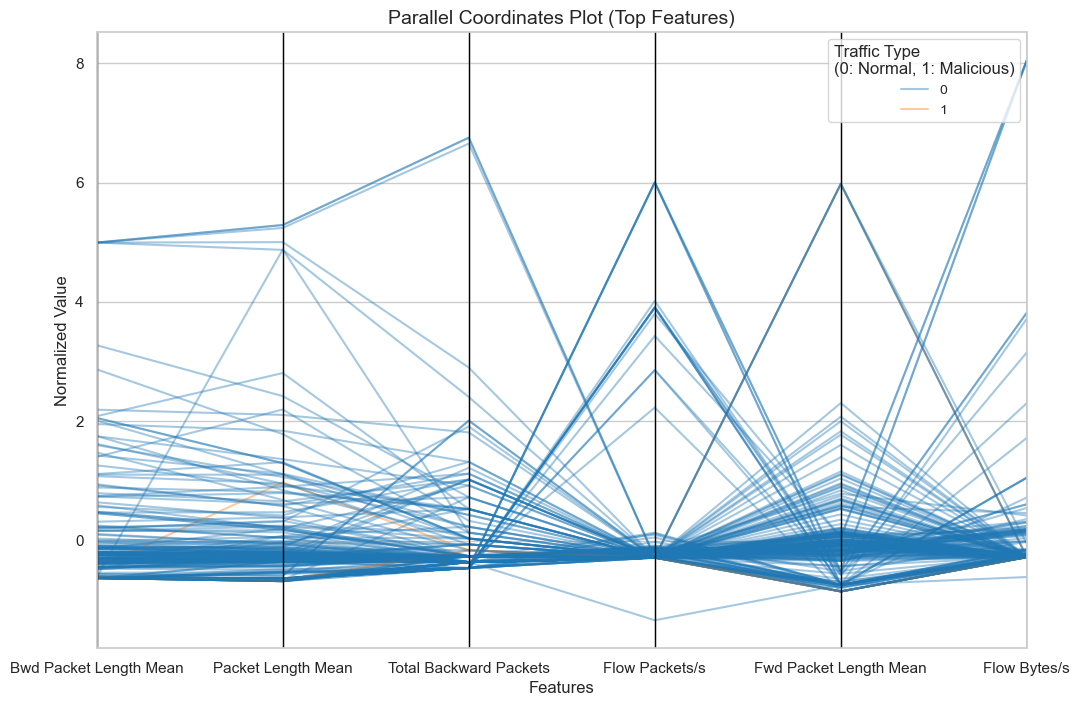

In [11]:
# Identify the top features by importance
importances = model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]  # Sort indices in descending order
top_n = 6  # Choose top 6 features for clarity
top_features = [features[i] for i in sorted_idx[:top_n]]

# Create a DataFrame with the top features and the target label
df_top = df_selected[top_features + ['Label']].copy()

# Sample data to avoid overcrowding in the plot
df_sampled = df_top.sample(n=200, random_state=42)

# Plot parallel coordinates
plt.figure(figsize=(12, 8))
parallel_coordinates(df_sampled, class_column='Label', color=['#1f77b4', '#ff7f0e'], alpha=0.4)
plt.title('Parallel Coordinates Plot (Top Features)', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.legend(title='Traffic Type\n(0: Normal, 1: Malicious)', fontsize=10, loc='upper right')
plt.grid(True)
plt.show()


## Step 7: Summary

*Notes:*  
- In this notebook, we've covered the entire workflow for our malicious packet classification project.  
- We loaded the data, cleaned and normalized it, visualized key aspects, trained a Random Forest classifier, and evaluated its performance with various metrics.  
- This iterative process gave us insights into both the data and our model's behavior.
-Ryan Crosby 3/9/2025